In [1]:
import jax.numpy as np
from jax import grad, value_and_grad, jit, ops

import matplotlib.pyplot as plt
%matplotlib inline 

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses
import make_plot
import jax.random as random

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)
reload(make_plot)

<module 'make_plot' from '/Users/cholt/Google Drive/Python/torch_SSN/jax_caleb/make_plot.py'>

In [2]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
# NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lib/xla_bridge.py:109: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
params = [1.95, 1.25, 2.45, 1.5, 1.25] #Jee, Jei, Jie, Jii, i2e --- Modelo that WORKED! w/ locality = 1
Ne = 21 * 21
Ni = Ne

N = Ne + Ni #number of neurons in the grid.

In [4]:
#unpack parameters
Jee = params[0]
Jei = params[1]
Jie = params[2]
Jii = params[3]

if len(params) < 6:
    i2e = params[4]
    gE = 1
    gI = 1
    NMDAratio = 0.4
else:
    i2e = 1
    gE = params[4]
    gI = params[5]
    NMDAratio = params[6]
    
# cons = len(contrasts)

J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) # * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
# ssn = SSN_classes.SSN_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())

# r_init = np.zeros([ssn.N, len(contrasts)])
# inp_vec = np.array([[gE], [gI*i2e]]) * contrasts

# r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)

# spect, fs, f0, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)



In [5]:
hyper_col = 8 #this defines the hyper column. In the MATLAB code it's called lambdaC. 

gridperdeg = 5
gridsizedeg = 4

gridsize = (1 + round(gridperdeg * gridsizedeg))

# length of the x/y directions in degress
Lx = 4 # in degrees\
Ly = 4
dx = Lx/(gridsize - 1)
dy = Ly/(gridsize - 1)

[X,Y] = np.meshgrid(np.arange(0, Lx+dx, dx),np.arange(0, Ly+dy, dy))


In [6]:
kc = 2*np.pi/(hyper_col)

z = np.zeros_like(X)
nn = 30 #number of plane waves in ori map
key = random.PRNGKey(0)
subkey = key

for j in range(nn):
    kj = kc * np.array([np.cos(j * np.pi/nn), np.sin(j * np.pi/nn)])
    
    #this won't work, gotta remember how to do random numbers in jax. 
    sj = 2 * random.randint(subkey, shape=(), minval=1, maxval=3)-3 #random number that's either + or -1. 
    #randint inputs: PRNGkey, size tuple, minval (incl), maxval(excl)
    
    phij = random.uniform(subkey)*2*np.pi
    
    tmp = (X*kj[0] + Y*kj[1]) * sj + phij
    
    z = z + np.exp(1j * tmp)

#     phij = rand()*2*pi;

#     tmp = (X*kj(1)+Y*kj(2))*sj + phij;

#     z = z + exp(1i * tmp);
    
    key, subkey = random.split(key)

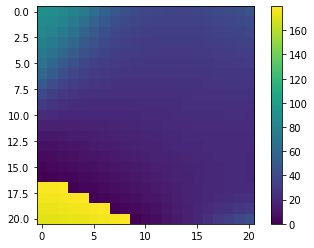

In [7]:
OMap = np.angle(z)
OMap = (OMap - np.min(OMap)) * 180/(2*np.pi)

Len = OMap.shape
Lm = Len[0]
Nthetas = len(OMap.ravel())



plt.imshow(OMap)
plt.colorbar()

In [66]:
PERIODIC = True

[indX, indY] = np.meshgrid(np.arange(21), np.arange(21))

# XDist = np.abs(np.ravel(X, 'F')[:,None] - np.ravel(X, 'F'))
XDist = np.abs(np.ravel(indX, 'F') - np.ravel(indX, 'F')[:,None])
# XDist = np.abs(XdMat - XdMat.T)

# YDist = np.abs(np.ravel(Y, 'F')[:,None] - np.ravel(Y, 'F'))
YDist = np.abs(np.ravel(indY, 'F') - np.ravel(indY,'F')[:,None])
# YDist = np.abs(YdMat - YdMat.T)

if PERIODIC:
    XDist = np.where( XDist > Len[0]/2, Len[0] - XDist, XDist) 
    YDist = np.where( YDist > Len[1]/2, Len[1] - YDist, YDist) 
#     XDist = np.where( XDist > Lx/2, Lx - XDist, XDist) 
#     YDist = np.where( YDist > Ly/2, Ly - YDist, YDist) 

OriPref = np.ravel(OMap)
OriDist = np.abs(OriPref - OriPref[:,None])
OriDist = np.where( OriDist > 90, 180- OriDist, OriDist)
# OriDist = np.abs(OridMat - OridMat.T)

deltaD = np.sqrt(XDist**2 + YDist**2)
deltaD = deltaD * Lx/(gridsize - 1)

In [74]:
JNoise_Normal = False
JNoise = 0

sigRat = 0.7

sigEE = 0.35 * np.sqrt(sigRat)
sigEI = 0.35 / np.sqrt(sigRat)
sigIE = 0.02 #small to enforce local I connections
sigII = 0.02 

sigOri = 45 #sigma for ori map. 

MinSyn = 1e-4

Wee_d = np.exp(-np.abs(deltaD)/sigEE)# - OriDist**2 / (2*sigOri**2))
Wee = np.exp(-np.abs(deltaD)/sigEE - OriDist**2 / (2*sigOri**2))
Wie = np.exp(-np.abs(deltaD)/sigIE - OriDist**2 / (2*sigOri**2))
Wei = np.exp(-deltaD**2/(2*sigEI**2) - OriDist**2 / (2*sigOri**2))
Wii = np.exp(-deltaD**2/(2*sigII**2) - OriDist**2 / (2*sigOri**2))

if JNoise_Normal:
    rand_dist = lambda x: random.normal(key, x.shape)
else:
    rand_dist = lambda x: 2*random.uniform(key, x.shape) - 1

Wee = (1 + (JNoise*rand_dist(Wee)))*Wee
Wei = (1 + (JNoise*rand_dist(Wei)))*Wei
Wie = (1 + (JNoise*rand_dist(Wie)))*Wie
Wii = (1 + (JNoise*rand_dist(Wii)))*Wii

Wee = np.where(Wee < MinSyn, 0, Wee)
Wie = np.where(Wie < MinSyn, 0, Wie)
Wei = np.where(Wei < MinSyn, 0, Wei)
Wii = np.where(Wii < MinSyn, 0, Wii)

In [75]:
tWee = np.sum(Wee_d, axis=1)
tWei = np.sum(Wei, axis=1)
tWie = np.sum(Wie, axis=1)
tWii = np.sum(Wii, axis=1)

if True: #default to true
    Wee_d = Wee_d / tWee
else:
    Wee = Wee/ mean(tWee)
    

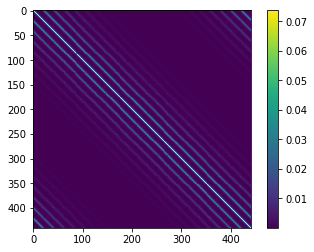

In [76]:
# plt.imshow(np.reshape(Wee_d[0, :], (21, 21), 'F'))
plt.imshow(Wee_d)
plt.colorbar()

# plt.imshow(XdMat.T)
# plt.colorbar()
# np.max(XdMat)

# plt.plot(indY)

In [80]:
def make_W_cat(dist, ori_dist, sigma, sigma_ori, from_neuron, MinSyn=1e-4, JNoise=0, JNoise_normal=False, CellWiseNormalized=True):
    
    if from_neuron == 'E':
        W = np.exp(-np.abs(dist)/sigma - ori_dist**2/(2*sigma_ori**2))
    elif from_neuron == 'I':
        W = np.exp(-dist**2/(2*sigma**2) - ori_dist**2/(2*sigma_ori**2))
    
    if JNoise_Normal:
        rand_dist = lambda x: random.normal(key, x.shape)
    else:
        rand_dist = lambda x: 2*random.uniform(key, x.shape) - 1
    
    W = (1 + (JNoise*rand_dist(W)))*W
    W = np.where(W < MinSyn, 0, W)
    tW = np.sum(W, axis=1)
    
    if CellWiseNormalized:
        W = W / tW
    else:
        W = W / np.mean(tW)
    
    return W        

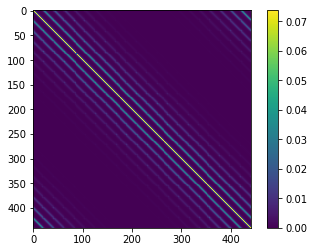

In [81]:
Wee = make_W_cat(deltaD, np.zeros_like(deltaD), sigEE, sigOri, 'E')

plt.imshow(Wee)
plt.colorbar()

In [71]:
np.max(np.sum(Wee_d, axis=1))

DeviceArray(13.576561, dtype=float32)

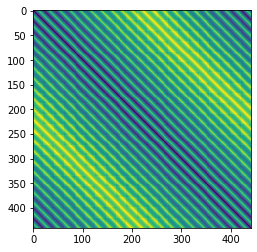

In [78]:
plt.imshow(deltaD)
# print(deltaD.shape)

dist = {"deltaD":deltaD, "Wee_d":Wee}

In [79]:
import scipy.io as sio
sio.savemat('dist_topo.mat', dist)